# Remote sensing in Python

In the second part of this week, we will use some of functions provided by `rasterio` to analyze remote sensing imagery. The data we will be using is a **Landsat 8** image over Florence, OR acquired in July 2021. Future courses (e.g. GEOG485: Remote Sensing 1) will cover remote sensing in more detail but the main thing to understand here is that remote sensing data often contains **multiple files**. Each file is a different **band** which represents the reflectance in a **specific wavelength** (e.g. red, green, or blue). Below are the band designations for Landsat 8. 

```{image} images/landsat_bands.jpg
:alt: landsat 8 bands
:class: bg-primary mb-1
:width: 600px
:align: center
```

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import glob

We can make a variable containing all the Landsat 8 files using the [`glob`](https://docs.python.org/3/library/glob.html) module which finds all the pathnames matching a specified pattern according to the rules used by the Unix shell. For example, `*.tif` returns all files in the `data/landsat/` folder that have the `.tif` file type.

In [5]:
# Define list of Landsat bands
files = sorted(glob.glob('data/landsat/*.tif'))
files

['data/landsat/band1.tif',
 'data/landsat/band2.tif',
 'data/landsat/band3.tif',
 'data/landsat/band4.tif',
 'data/landsat/band5.tif',
 'data/landsat/band6.tif',
 'data/landsat/band7.tif']

One of these bands can be opened in the same way we did in the previous lecture (i.e. `.open` and `.read`)

In [6]:
# Open a single band
src = rasterio.open(files[0])
band_1 = src.read(1)

The dataset's **profile** returns a dictionary containing the parameters that we returned individually before (i.e. `.bounds`, `.transform`).

In [8]:
# Find metadata (e.g. driver, data type, coordinate reference system, transform etc.)
print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1208, 'height': 1422, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0), 'tiled': False, 'interleave': 'band'}


We can plot a figure showing our data like so:

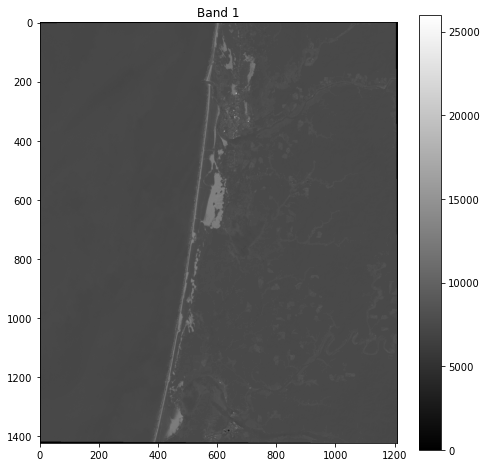

In [10]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray')
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

## Band indices 

Often in remote sensing, we compute indices to emphasize different land cover types. Indices are combinations of pixel values from multiple bands. A commonly used index is the **Normalized Difference Vegetation Index (NDWI)** which emphasizes live, green vegetation. NDVI is computed using the **red** and **near-infrared** bands which, in the case of Landsat 8, correspond to bands 4 and 5, respectively.

> NDVI = (Band 5 - Band 4) / (Band 5 + Band 4)

So let's go ahead and read these two bands.

```{caution}
Remember that Python uses zero indexing, so the first band (i.e. 0) corresponds to band 1.
```

In [99]:
src_4 = rasterio.open(files[3])
band_4 = src_4.read(1)

src_5 = rasterio.open(files[4])
band_5 = src_5.read(1)

We can now subtract and divide the bands to produce the NDVI. 

```{caution}
Note that we have to make sure our bands are converted to `float` datatypes before dividing.
```

In [100]:
np.seterr(divide='ignore', invalid='ignore')
ndvi = (band_5.astype(float) - band_4.astype(float)) / (band_5.astype(float) + band_4.astype(float))

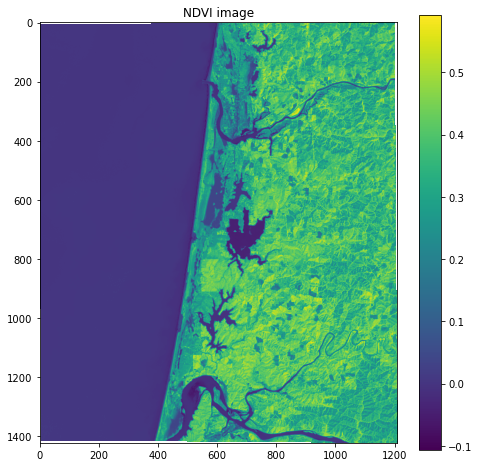

In [101]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, cmap='viridis')
ax.set_title("NDVI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In the figure, the high pixel values of healthy green forests make it distinguishable from other land cover types such as sand dunes and water.

Another popular index is the **Normalized Difference Water Index (NDWI)** which emphasizes pixels that contain water. The NDWI is computed using the **green** and **near-infrared** bands which, in the case of Landsat 8, correspond to bands 3 and 5, respectively.

> NDWI = (Band 3 - Band 5) / (Band 3 + Band 5)

In [102]:
src_3 = rasterio.open(files[2])
band_3 = src_3.read(1)

ndwi = (band_3.astype(float) - band_5.astype(float)) / (band_3.astype(float) + band_5.astype(float))

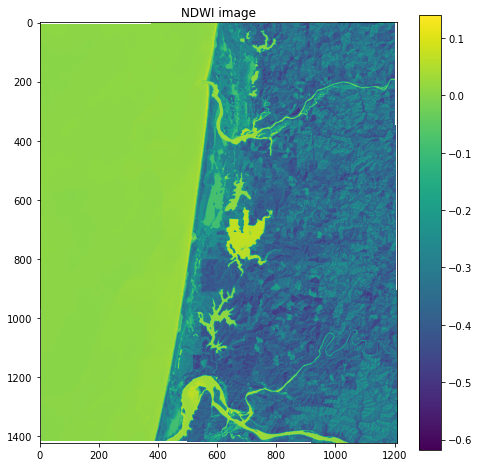

In [103]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, cmap='viridis')
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In this figure, the positive pixel values of water make it easily distinguishable from other land cover types such as sand dunes and forests.

## True color Landsat image

When making figures for presentations, we often want a "true color" background which combines the red, green, and blue bands to make an image similar to what the human eye would observe. 

We can actually pass a 3-band array to [`.imshow`](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html) and plot it as an RGB image because it is such a common image format. First, we will read the blue band and stack it with the red and green bands.

In [113]:
src_2 = rasterio.open(files[1])
band_2 = src_2.read(1)

In [114]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((band_4, band_3, band_2))

We know the the datatype of the image is `uint16`, which stands for unsigned 16-bit integer.

In [122]:
src_2.profile['dtype']

'uint16'

But `.imshow` requires our data to have a range of 0-255 or 0-1. We can scale the pixel values by dividing by the maximum `uint16` value (i.e. 2^16) and multiplying by our desired max value (i.e. 2^8). We also have to convert the variable to an `uint8` data type.

In [129]:
# Scale data
rgb_255 = np.uint8((rgb / 65536) * 255)
rgb_255.dtype

dtype('uint8')

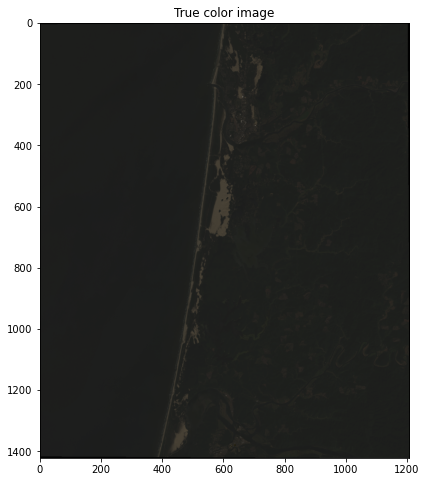

In [130]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb_255)
ax.set_title("True color image")
plt.show()

This looks great but is pretty dark because the range of pixel values is much less than 255 so there it is difficult to differentiate colors. 

In [137]:
rgb_255.min(), rgb_255.max()

(0, 123)

One way of dealing with this is to **stretch** the image using a **percentile clip**. This technique redistributes all pixel values between 0 and 255. In our case, all values of 0 will remain at 0, values of 123 will become 255, and the rest of the values will be spread proportionally in between. 

In [138]:
def percentile_stretch(array, pct = [2, 98]):
    
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    stretch = (array - array_min) / (array_max - array_min)
    
    stretch[stretch > 1] = 1
    stretch[stretch < 0] = 0
    
    return stretch

# Call function
array = percentile_stretch(rgb_255)

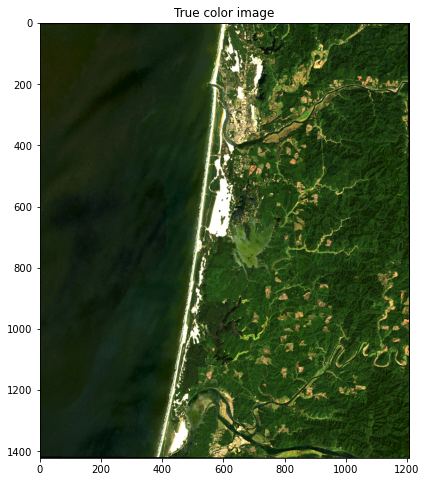

In [139]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(array)
ax.set_title("True color image")
plt.show()

This looks much nicer.